## Constraint data generation

For an effective training of a model capable of detecting constraints in real data training data has to be generated which resembles the intended purpose as close as possible.

For this previously hand written data of nodes and constraints is used.
Examples for the used data include the following:

In [1]:
import os
from os import path

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

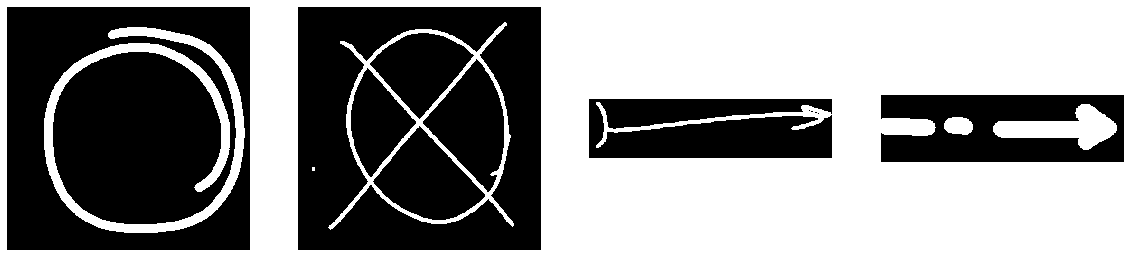

In [2]:
raw = path.join('data', 'sep_raw_01')
interim = path.join('data', 'sep_interim_01')

os.makedirs(interim, exist_ok=True)

node_example  = path.join(raw, 'o', '0.png')
base_example  = path.join(raw, 'x', '0.png')
rot_example   = path.join('data', 'sep_raw_02', 'r', '350-449', '0.png')
trans_example = path.join('data', 'sep_raw_02', 't', '350-449', '0.png')

node_img = cv2.imread(node_example, cv2.IMREAD_GRAYSCALE)
base_img = cv2.imread(base_example, cv2.IMREAD_GRAYSCALE)
rot_img = cv2.imread(rot_example, cv2.IMREAD_GRAYSCALE)
trans_img = cv2.imread(trans_example, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,20))

for idx, example in enumerate([node_img, base_img, rot_img, trans_img]):
    plt.subplot(1, 4, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(example)

plt.show()

### Prepare node images

For the constraints to connect nodes, images have to be generated which contain connectable nodes with the following properties:

- Generated images have a target size of 360x360.
- Number of placed nodes can vary between 3 and 10 per image.
- Node-types are selected in a 50/50 fashion.
- Nodes are placed, but only accepted if their minimum distance is > 60.
- Loaded images are then flipped and rotated (also random).
- Coordinates are centered in the middle of the image (not the top left).

Saved metadata is then saved into a `config.json`.

In [3]:
image_width = 360
image_height = 360

data_list = []

num_examples = 100000

for image_idx in tqdm(range(num_examples)):
    name = str(image_idx) + '.png'
    image_data = {
        'image_path': path.join(interim, name),
        'nodes': []
    }
    image = np.zeros((image_height, image_width), np.uint8)
    # Pick random nodes and assign coordinates:
    num_nodes = int(np.random.uniform(3, 10))
    for node_idx in range(num_nodes):
        label = np.random.choice(['o', 'x'])
        node_dir = path.join(raw, label)
        node_path = path.join(
            node_dir, np.random.choice(os.listdir(node_dir)))

        # Set x and y so that they do not collide with other nodes:
        x = None
        y = None
        def check_collision(x, y, node_list):
            for node in node_list:
                if abs(x - node['x']) <= 60 and abs(y - node['y']) <= 60:
                    return False
            return True

        while True:
            x = int(np.random.uniform(16, image_width-16))
            y = int(np.random.uniform(16, image_height-16))
            if check_collision(x, y, image_data['nodes']):
                break

        node_image = cv2.imread(node_path, cv2.IMREAD_GRAYSCALE)
        node_image = cv2.resize(node_image, (32, 32))
    
        # Flip and rotate images randomly:
        if np.random.choice([True, False]):
            node_image = cv2.flip(node_image, 0)
        if np.random.choice([True, False]):
            node_image = cv2.flip(node_image, 1)
        M = cv2.getRotationMatrix2D(
            (16, 16), np.random.uniform(0, 360), 1)
        node_image = cv2.warpAffine(node_image, M, node_image.shape)

        image[y-16:y+16, x-16:x+16] = node_image

        cv2.imwrite(image_data['image_path'], image)

        image_data['nodes'].append({
            'node_path': node_path,
            'label': label,
            'x': x,
            'y': y,
            'b': 32,
            'h': 32
        })
    data_list.append(image_data)

df = pd.DataFrame(data_list)
df.to_json(path.join(interim, 'config.json'))

100%|██████████| 100000/100000 [32:25<00:00, 51.41it/s]


The created `config.json` has the following `head`:

In [4]:
df.head()

,image_path,nodes
0,data/sep_interim_01/0.png,"[{'node_path': 'data/sep_raw_01/o/757.png', 'l..."
1,data/sep_interim_01/1.png,"[{'node_path': 'data/sep_raw_01/x/1094.png', '..."
2,data/sep_interim_01/2.png,"[{'node_path': 'data/sep_raw_01/o/1199.png', '..."
3,data/sep_interim_01/3.png,"[{'node_path': 'data/sep_raw_01/x/1164.png', '..."
4,data/sep_interim_01/4.png,"[{'node_path': 'data/sep_raw_01/o/501.png', 'l..."


Examples for the generated images:

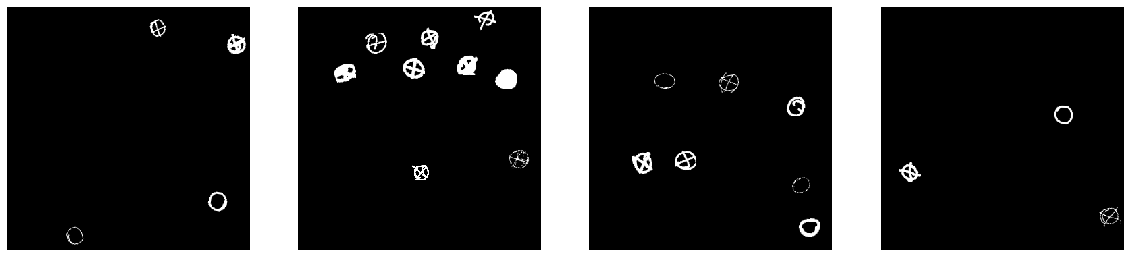

,node_path,label,x,y,b,h
0,data/sep_raw_01/o/757.png,o,311,289,32,32
1,data/sep_raw_01/x/617.png,x,220,32,32,32
2,data/sep_raw_01/o/247.png,o,101,339,32,32
3,data/sep_raw_01/x/880.png,x,340,56,32,32


In [5]:
plt.figure(figsize=(20,20))

for idx, image_path in enumerate(os.listdir(interim)[:4]):
    image = cv2.imread(path.join(interim, image_path), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

pd.DataFrame(df.nodes[0])

In the next notebook (`2.2.2-connecting_nodes.ipynb`) these nodes will be connected using the raw data of constraints.